## U shape PHP dynamics with multiple liquid slugs - with heat transfer

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using DifferentialEquations

In [3]:
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing



## Parameters of the PHP

In [4]:
    ω0 = [sqrt(1.2e004), sqrt(1.2e004)];
    ℘ = [1.2e005, 1.2e005];


     Θ = 0.15;
    θe = 1 + Θ;
    θc = 1 - Θ;
    
    He = 3000.0;
    Hc = 3000.0;
    
    X0 = 0.5;

    γ = 1.4;

In [5]:
    L = 8.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    alpha = pi/2 # inclination angle 

1.5707963267948966

## Pipe definition

In [6]:
tube = Tube(L,L2D,alpha)

Tube(8.0, 2.0, 1.5707963267948966)

## Evaporator and condenser definition

In [7]:
Xe = map(tuple, [0.0; 3.0; 7.0], [1.0; 5.0; 8.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 5.0), (7.0, 8.0)])

In [8]:
Xc = map(tuple, [1.0; 5.0], [3.0; 7.0])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0), (5.0, 7.0)])

## Vapor plug and liquid slug initialization

In [9]:
X0 = [(0.5,2.5),(5.0,7.0)]
dXdt0 = [(0.0,0.0),(0.0,0.0)]
liquids=LiquidSlug(γ,ω0,℘,X0,dXdt0)

LiquidSlug(1.4, [109.54451150103323, 109.54451150103323], [120000.0, 120000.0], Tuple{Float64,Float64}[(0.5, 2.5), (5.0, 7.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)])

In [10]:
P = [1.0,1.0,1.0];
vapors=VaporPlug(γ,P)

VaporPlug(1.4, [1.0, 1.0, 1.0])

## Construct the system

In [11]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors)

PHPSystem(Tube(8.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 5.0), (7.0, 8.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0), (5.0, 7.0)]), LiquidSlug(1.4, [109.54451150103323, 109.54451150103323], [120000.0, 120000.0], Tuple{Float64,Float64}[(0.5, 2.5), (5.0, 7.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)]), VaporPlug(1.4, [1.0, 1.0, 1.0]))

In [12]:
typeof(sys0)

PHPSystem

## Construct the state vector U

In [13]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L)
M = P.^(1/γ).* Lvaporplug
u=XMtovec(X0,dXdt0,M)

11-element Array{Float64,1}:
 0.5
 2.5
 5.0
 7.0
 0.0
 0.0
 0.0
 0.0
 0.5
 2.5
 1.0

 ## $\textbf{U}=\left(\begin{array}{c}  X_{p1}   \\  X_{p2} \\  X_{p3} \\  X_{p4} \\ \frac{\mathrm{d} X_{p1}}{\mathrm{d} \tau}  \\ \frac{\mathrm{d} X_{p2}}{\mathrm{d} \tau}   \\ \frac{\mathrm{d} X_{p3}}{\mathrm{d} \tau}   \\ \frac{\mathrm{d} X_{p4}}{\mathrm{d} \tau} \\ M_{1} \\ M_{2} \\ M_{3} \end{array}\right)$.

## Solve the constructed ODE for U

In [14]:
tstep=1.0e-5

p = sys0
tspan = (0.0, 1.0);
prob = ODEProblem(zhang2002model!, u, tspan, p)
sol = solve(prob, RK4(), adaptive=false, dt=tstep);

In [15]:
result1=soltoResult(sol,sys0);

## Convert and plot the results

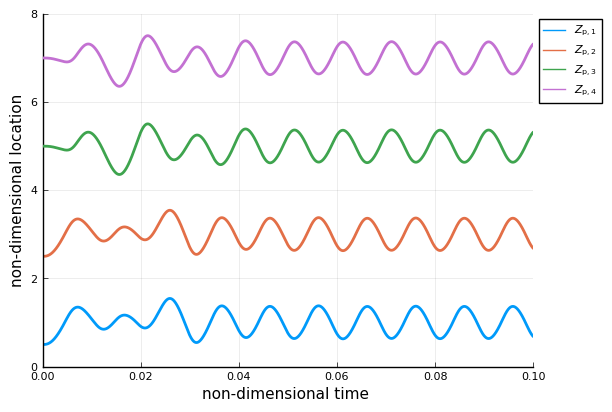

In [20]:
plot(result1.t,result1.Xp[1],label="\$Z_{\\mathrm{p},1}\$",linewidth=2.0)
plot!(result1.t,result1.Xp[2],label="\$Z_{\\mathrm{p},2}\$",linewidth=2.0)
plot!(result1.t,result1.Xp[3],label="\$Z_{\\mathrm{p},3}\$",linewidth=2.0)
plot!(result1.t,result1.Xp[4],label="\$Z_{\\mathrm{p},4}\$",linewidth=2.0, xlim=(0.0,0.1),ylim=(0.0,8.0),xlabel="non-dimensional time ",ylabel="non-dimensional location",legend = :outertopright)

savefig("WtubeZ.pdf")

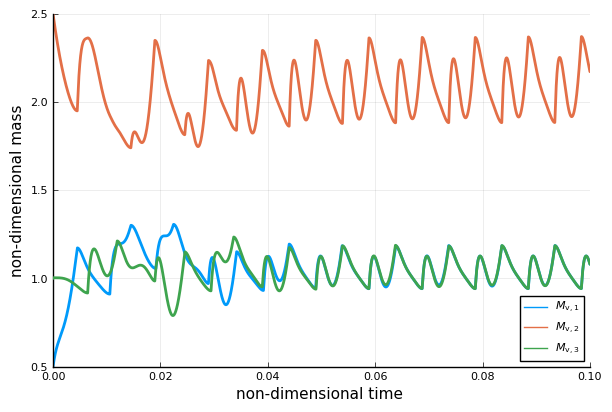

In [21]:
plot(result1.t,result1.M[1],label="\$M_{\\mathrm{v},1}\$",linewidth=2.0)
plot!(result1.t,result1.M[2],label="\$M_{\\mathrm{v},2}\$",linewidth=2.0)
plot!(result1.t,result1.M[3],label="\$M_{\\mathrm{v},3}\$",linewidth=2.0, xlim=(0.0,0.1),ylim=(0.5,2.5),xlabel="non-dimensional time ",ylabel="non-dimensional mass")
savefig("WtubeM.pdf")